In [21]:
from __future__ import print_function, division
import os, glob, argparse
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import lr_scheduler
from scipy.ndimage import imread
import cv2
import shutil
import time

In [904]:
class HangulDataset(Dataset):
    """Hangul Handwritten dataset."""

    def __init__(self, root_dir, subroot='char_data', transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.subroot = subroot
        self.transform = transform
        self.classlist = os.listdir(os.path.join(root_dir, self.subroot))
        self.targets = []
        self.filenames = []
        self.targetdict = {}
        for i, label in enumerate(self.classlist):
            files = glob.glob(
                        os.path.join(self.root_dir, self.subroot, label) + '/*')
            self.filenames += files
            self.targets += [i] * len(files)
            self.targetdict[i] = int(label, 16)
            
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        target = self.targets[idx]
        sample = imread(img_name, mode='L')
        if self.transform:
            sample = self.transform(sample)
        return (sample, target)
    
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or tuple): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (self.output_size, self.output_size),
                               mode='reflect')
        return img
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return image
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        dims = sample.shape
        if len(dims) == 2:
            image = np.expand_dims(sample, 0)
        else:
            image = sample.transpose((2, 0, 1))
        sampletensor = torch.from_numpy(image)
        return sampletensor.type(torch.FloatTensor)
    
class ObjectCrop(object):
    """Use findContours function of OpenCV to detect object and crop the images"""            
    def __call__(self, sample):
        # Find contours
        (_, contours, _) = cv2.findContours(sample.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # if no contour found
        if len(contours) == 0:
            return sample

        # one contour found
        if len(contours) == 1:
            [x, y, w, h] = cv2.boundingRect(contours[0])
            yh = y + h
            xw = x + w

        # multiple contours found
        else:
            for i, contour in enumerate(contours):
                if i==0:
                    [x, y, w, h] = cv2.boundingRect(contour)
                    yh = y + h
                    xw = x + w
                else:
                    [new_x, new_y, new_w, new_h] = cv2.boundingRect(contour)
                    # Ignore too narrow contours (outliers)
                    if new_w < 5or new_h < 5:
                        continue
                    new_yh = new_y + new_h
                    new_xw = new_x + new_w
                    if new_x < x:
                        x = new_x
                    if new_y < y:
                        y = new_y
                    if new_yh > yh: 
                        yh = new_yh
                    if new_xw > xw:
                        xw = new_xw
        if yh-y < 50 or xw-x < 50:
            return sample
        else:
            return sample[y:yh, x:xw]
        
class Denoise(object):
    """Stablize pixel values of images."""
    def __call__(self, sample):
        sample = cv2.threshold(sample, 225, 255, cv2.THRESH_BINARY_INV)[1]
        return sample
    
class Normalize(object):
    """Normalize images."""
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, sample):
        return (sample - self.mean) / self.std

In [921]:
hangul_dataset = HangulDataset('set01', transform =
                               transforms.Compose([Denoise(), ObjectCrop()]))
# hangul_dataset = HangulDataset('set01')
transformed_dataset = HangulDataset(root_dir='set01',
                                    transform=transforms.Compose([
                                    Denoise(),
                                    ObjectCrop(),
                                    Normalize(50.81, 110.16),
                                    Rescale(224),
                                    ToTensor(),  
                                    transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
                                           ]))
dataloader = DataLoader(transformed_dataset, batch_size=100,
                        shuffle=True)

### Show sample image

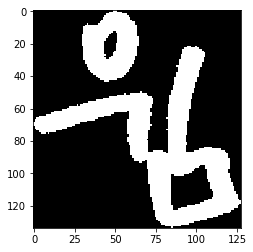

In [906]:
idx = int(np.random.rand(1)*len(transformed_dataset))
plt.imshow(hangul_dataset[idx][0], cmap='gray')
plt.show()

### Show transformed image

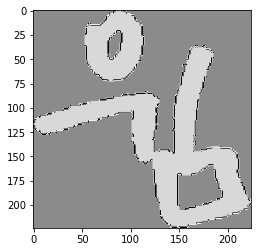

In [907]:
plt.imshow(transformed_dataset[idx][0].numpy().transpose(1,2,0))
plt.show()

0 torch.Size([100, 3, 224, 224])
1 torch.Size([100, 3, 224, 224])
2 torch.Size([100, 3, 224, 224])
3 torch.Size([100, 3, 224, 224])


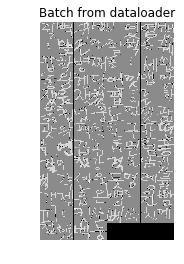

In [922]:
def show_batch(sample_batched):
    """Show images for a batch of samples."""
    batch_size = len(sample_batched)
    im_size = sample_batched.size(2)

    grid = utils.make_grid(sample_batched)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')

for i_batch, (sample_batched, target_batched) in enumerate(dataloader):
    print(i_batch, sample_batched.size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [923]:
pretrained_model = models.vgg19_bn(pretrained=True)

In [924]:
# create custom VGG19_bn
num_classes = 2350
class CustomVGG19bn(nn.Module):
    def __init__(self, num_classes):
        super(CustomVGG19bn, self).__init__()
        self.features = nn.Sequential(*list(pretrained_model.features.children()))
        self.classifier = nn.Sequential(
            *[list(pretrained_model.classifier.children())[i] for i in range(6)],
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 25088)
        x = self.classifier(x)
        return x

# load custom model
model = CustomVGG19bn(num_classes=2350)

In [925]:
for param in model.parameters():
    param.requires_grad = False
for layer_idx, param in enumerate(model.classifier.parameters()):
    param.requires_grad = True

In [11]:
# unfrozen_weights = filter(lambda x: x.requires_grad, model.parameters())
# print(list(map(lambda x: x.size(), unfrozen_weights)))

[torch.Size([4096, 25088]), torch.Size([4096]), torch.Size([4096, 4096]), torch.Size([4096]), torch.Size([2350, 4096]), torch.Size([2350])]


In [942]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase]):
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    if phase == 'train':
                        inputs = Variable(inputs).float().cuda()
                        labels = Variable(labels).long().cuda()
                    else:
                        inputs = Variable(inputs, volatile=True).float().cuda()
                        labels = Variable(labels, volatile=True).long().cuda()
                else:
                    if phase == 'train':
                        inputs, labels = Variable(inputs).float(), Variable(labels).long()
                    else:
                        inputs, labels = Variable(inputs, volatile=True).float(), Variable(labels, volatile=True).long()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                
                # print every 10 iterations
                if (i+1) % 10 == 0:
                    print('Epoch: {0:}/{1:}, Iterations: {2:}/{3:}, Training loss: {4:6.2f}'.
                     format(epoch+1, num_epochs, i+1, len(dataloaders[phase]), loss.data[0]))

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects / len(dataloaders[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [943]:
# train, test data split
num_data = len(hangul_dataset.filenames)
indices = list(range(num_data))
np.random.seed(42)
np.random.shuffle(indices)

val_size = 0.20
test_size = 0.20
test_split = int(np.floor(test_size * num_data))
val_split = test_split + int(np.floor(val_size * num_data))
num_train = num_data - val_split - test_split
train_idx, val_idx, test_idx = indices[val_split:], indices[test_split:val_split] , indices[:test_split]

# Hyper Parameters
num_epochs = 1
batch_size = 100
learning_rate = 0.0001

 # Define sampler
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Train, test dataset loader
train_loader = DataLoader(transformed_dataset, 
                        batch_size=batch_size, sampler=train_sampler)

val_loader = DataLoader(transformed_dataset, 
                        batch_size=batch_size, sampler=val_sampler)

test_loader = DataLoader(transformed_dataset, 
                        batch_size=batch_size, sampler=test_sampler)

dataloaders = {'train':train_loader, 'val':val_loader}

 # use gpu if cuda is available
use_gpu = torch.cuda.is_available()

if use_gpu:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [944]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders,
                       num_epochs=num_epochs)

Epoch 1/1
----------
Epoch: 1/1, Iterations: 10/1841, Training loss:   7.75
Epoch: 1/1, Iterations: 20/1841, Training loss:   7.79
Epoch: 1/1, Iterations: 30/1841, Training loss:   7.77
Epoch: 1/1, Iterations: 40/1841, Training loss:   7.77
Epoch: 1/1, Iterations: 50/1841, Training loss:   7.77
Epoch: 1/1, Iterations: 60/1841, Training loss:   7.78
Epoch: 1/1, Iterations: 70/1841, Training loss:   7.77
Epoch: 1/1, Iterations: 80/1841, Training loss:   7.77
Epoch: 1/1, Iterations: 90/1841, Training loss:   7.79
Epoch: 1/1, Iterations: 100/1841, Training loss:   7.72
Epoch: 1/1, Iterations: 110/1841, Training loss:   7.75
Epoch: 1/1, Iterations: 120/1841, Training loss:   7.71
Epoch: 1/1, Iterations: 130/1841, Training loss:   7.79
Epoch: 1/1, Iterations: 140/1841, Training loss:   7.71
Epoch: 1/1, Iterations: 150/1841, Training loss:   7.69
Epoch: 1/1, Iterations: 160/1841, Training loss:   7.74
Epoch: 1/1, Iterations: 170/1841, Training loss:   7.64
Epoch: 1/1, Iterations: 180/1841, Tr

KeyboardInterrupt: 